# Trying out an LSTM setup
## Using generated data
### Bi-directional LSTM with adversarial softmax layer

In [1]:
import numpy as np
import gym

def cart_pole(observation):
        
        position, velocity, angle, angle_velocity = observation
        action = int(3. * angle + angle_velocity > 0.)
        return action
        
def mountain_car(observation):

    position, velocity = observation
    lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
            0.3 * (position + 0.9) ** 4 - 0.008)
    ub = -0.07 * (position + 0.38) ** 2 + 0.07
    end = position > 0.2 and velocity > 0.02
    hard_end = position > 0.45
    begin = position < -0.45 and velocity < 0.001 and velocity > -0.001
    if begin or (lb < velocity < ub) or end or hard_end:
        action = 2 
    else:
        action = 0
    return action

class Expert(object):
        
    
    def __init__(self, env_name):
        
        policies = {
            'CartPole-v0': cart_pole,
            'MountainCar-v0': mountain_car
        }
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        self.policy = policies[env_name]
        
    def generate_data(self, num_episodes=1):

        trajectories = []
        rewards = []
        splits = []
        counter = 0
        for i in range(num_episodes):


            observation = self.env.reset()
            done = False
            rd = 0
            
            while not done:

                action = self.policy(observation)
                trajectories.append(
                    [
                        feature for feature in observation
                    ] + [action] + [i]
                )
                observation, reward, done, _ = self.env.step(action)
                rd += reward
                counter += 1
            
            rewards.append(rd)
            splits.append(counter)
                
        return np.array(trajectories), np.mean(rewards), splits

### Generate data

In [2]:

expert = Expert('MountainCar-v0')
NUMBER_OF_EPISODES = 50
data, avg_reward, splits = expert.generate_data(NUMBER_OF_EPISODES)
avg_reward

-103.72

### Plot expert data

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

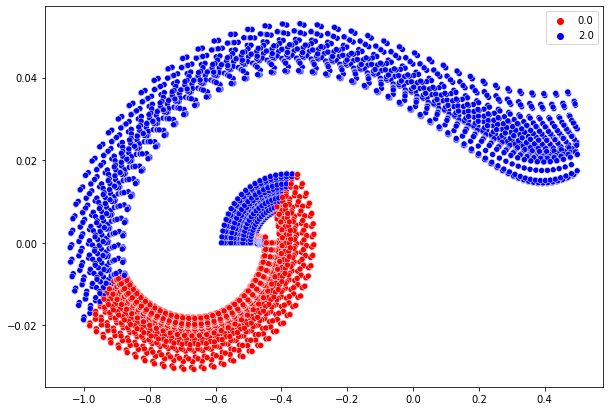

In [4]:
colors = np.array(['red', 'green', 'blue'])
palette = colors[np.unique(data[:,2]).astype(int)].tolist()

fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=data[:,2], palette=palette)

### Preprocess data into sequences

In [5]:
X_partitioned = np.split(data, splits)[0:NUMBER_OF_EPISODES]
max_len = 200
for i in range(len(X_partitioned)):

  for j in [1, 5, 10, 20]:

    X_partitioned.append(X_partitioned[i][0:j])

X_partitioned_test = np.split(data, splits)[0:NUMBER_OF_EPISODES]

In [6]:
import torch
torch.cuda.CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda:0')

In [7]:
def seq_to_x(seq, pad_to):
    
    return [
            [seq[i][0], seq[i][1], int(i==0), 0] if i < len(seq)
            else [99, 99, 0, 1]
            for i in range(pad_to)
        ]

def seq_to_target(seq, pad_to):
    
    return [
            seq[i][2] if i < len(seq) else 1 for i in range(pad_to)
        ]


def training_X(data, max_len):
    
    return torch.tensor(
        np.array(
            [
                seq_to_x(seq, max_len) for seq in data
            ],
            dtype=np.float
        ),
        dtype=torch.float
    )

def training_Y(data, max_len):
    
    return torch.tensor(
        [
            seq_to_target(seq, max_len) for seq in data
        ],
        dtype=torch.long
    )

def true_indicies(Y):
    
    true = []
    for i in range(Y.shape[0]):
        
        if Y[i] == 0 or Y[i] == 2:
            true.append(i)
    
    return true

In [20]:
X = training_X(X_partitioned, max_len).to(device)
X_test = training_X(X_partitioned_test, max_len).to(device)
X.view(-1, 2).shape

RuntimeError: ignored

In [19]:
Y = torch.unsqueeze(training_Y(X_partitioned, max_len), dim=2).to(device)
#Y_test = training_Y(X_partitioned_test, max_len)
true = true_indicies(Y.view(-1))


RuntimeError: ignored

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PolicyLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, target_size):
        
        super(PolicyLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=1,
            bias=True,
            batch_first=True,
            bidirectional=False
        )
        
        self.linear = nn.Linear(hidden_dim, target_size)
        
        self.output = nn.LogSoftmax(dim=2)
        
    def forward(self, batch):
        
        lstm_out, _ = self.lstm(batch)
        #print(lstm_out.shape)
        linear_out = self.linear(lstm_out)
        #print(linear_out.shape)
        out = self.output(linear_out)
        #print(out.shape)
        return out
    
    def predict(self, X):
        
        with torch.no_grad():
            pred = self.forward(X)
        
        return torch.argmax(pred, dim=2).view(-1)

model = PolicyLSTM(4, 15, 3).to(device)

In [14]:
def train(xdata, ydata, model, n_epochs, lr=0.01, print_every=100):
    '''Train the neural model with the given training data'''

    criterion = torch.nn.NLLLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 


    for epoch in range(n_epochs):
        
        model.zero_grad()
        
        Y_pred = model(xdata)
        
        #print(ydata[99])
        loss = criterion(Y_pred.view(-1, 3), ydata.view(-1))
        
        if epoch % print_every == 0: print('epoch: ', epoch,' loss: ', loss.item()) 
        #if loss.item() < 0.10: lr=0.001
        #if loss.item() < 0.075: lr=0.0005
        loss.backward()

        optimizer.step()
        
    return model

In [15]:
train(X, Y, model, 25000, lr=0.01, print_every=1000)

epoch:  0  loss:  0.10218827426433563
epoch:  1000  loss:  0.09922361373901367
epoch:  2000  loss:  0.09736552089452744
epoch:  3000  loss:  0.09614056348800659
epoch:  4000  loss:  0.09525330364704132
epoch:  5000  loss:  0.09457478672266006
epoch:  6000  loss:  0.09403235465288162
epoch:  7000  loss:  0.09358105808496475
epoch:  8000  loss:  0.09319572895765305
epoch:  9000  loss:  0.09285479784011841
epoch:  10000  loss:  0.09254560619592667
epoch:  11000  loss:  0.09225780516862869
epoch:  12000  loss:  0.09198356419801712
epoch:  13000  loss:  0.09171821177005768
epoch:  14000  loss:  0.0914556086063385
epoch:  15000  loss:  0.09118903428316116
epoch:  16000  loss:  0.09091474860906601
epoch:  17000  loss:  0.09063344448804855
epoch:  18000  loss:  0.09033922106027603
epoch:  19000  loss:  0.09003250300884247
epoch:  20000  loss:  0.08971577882766724
epoch:  21000  loss:  0.08938844501972198
epoch:  22000  loss:  0.08905641734600067
epoch:  23000  loss:  0.08871874213218689
epoch:

PolicyLSTM(
  (lstm): LSTM(4, 15, batch_first=True)
  (linear): Linear(in_features=15, out_features=3, bias=True)
  (output): LogSoftmax(dim=2)
)

In [18]:
preds = model.predict(X_test)[true]
preds

RuntimeError: ignored

NameError: ignored

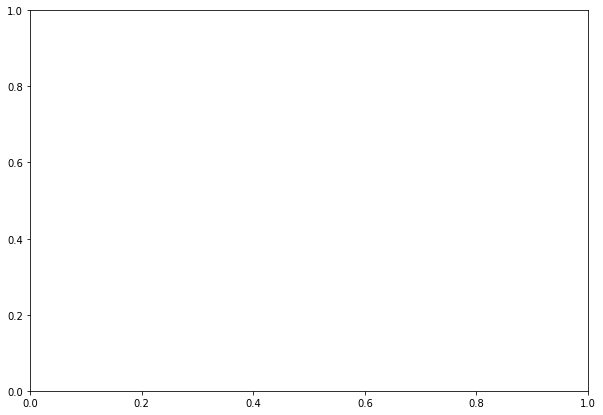

In [17]:
fig, ax = plt.subplots(figsize=(10,7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=preds, palette=['red', 'blue'])

In [ ]:
env = gym.make('MountainCar-v0')
rewards = []


for i in range(1):

  # print(i)
  observation = env.reset()
  done = False
  rd = 0
  traj = torch.unsqueeze(torch.tensor([[observation[0], observation[1], 0, 1]], dtype=torch.float), dim=0).to(device)
  # print(observation)
  while not done:
  
    action = model.predict(traj)
    # print(action[-rd].item())
    observation, reward, done, _ = env.step(int(action[-rd].item()))
    rd += int(reward)
    traj = torch.cat(
        [
          traj,
          torch.unsqueeze(
              torch.tensor(
                    [[ob for ob in observation]+[0,0]],
                    dtype=torch.float
                  ).to(device),
                  dim=1
            )
        ]
    ).to(device)
    print(traj)

  rewards.append(rd)

np.mean(rewards)